In [1]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler
import math

Step 0: Compute the mean std, and var for each KPI
Step 1: Normalize the dataset (mean var)
Step 2: Compute threshold 3 * std + mean/median using normalized value sum square sqrt(kpi1^2 + kpi2^2) for each timestamp
Step 3: Production normalize using normal data and compute sqrt(kpi1^2 + kpi2^2) for each timestamp and compare with threshold
Step 4: If above threshold: prediction yes, then localization. Get KPIs higher than threshold for KPI (anomalous KPIs) compared with 3 (mean is 0) (try)
Step 5: Anomalous KPIs Grouped by services to localize


## Load Dataset

In [2]:
PATH_DATASET_FOLDER = "./input/datasets/Consolidated"
PATH_NORMAL_DATASET = os.path.join(PATH_DATASET_FOLDER, "normal_1_14.csv")
PATH_FAILURE_DATASET_FOLDER = os.path.join(PATH_DATASET_FOLDER, "failure-experiments")
PATH_FAILURE_LOGS = "./input/other/failure-injection-log.csv"
# PATH_DATASET_CONFIG = "data_sets_config.csv"

In [3]:
with open(
    "./input/other/services.yaml"
) as fp:
    SERVICES = yaml.safe_load(fp)["services"]

In [4]:
df_normal = pd.read_csv(PATH_NORMAL_DATASET)
if "timestamp" in df_normal:
    df_normal.set_index("timestamp", inplace=True)
print(f"Shape of the preprocessed normal dataset: {df_normal.shape}")

Shape of the preprocessed normal dataset: (20074, 4702)


In [5]:
df_failure_logs = pd.read_csv(PATH_FAILURE_LOGS)

In [225]:
# df_dataset_config = pd.read_csv(PATH_DATASET_CONFIG)

In [7]:
# dict of failure name -> DataFrame
failure_experiment_dict = {
    experiment: pd.read_csv(
        os.path.join(PATH_FAILURE_DATASET_FOLDER, f"{experiment}.csv")
    ).set_index("timestamp")
    for experiment in df_failure_logs["folder_name"]
}

In [8]:
print(f"Shape of failure datasets:")
for failure_name, df_failure in failure_experiment_dict.items():
    print(failure_name + ":", df_failure.shape)

Shape of failure datasets:
linear-cpu-stress-userapi-051516: (181, 4389)
linear-memory-stress-userapi-051218: (181, 4446)
linear-network-delay-userapi-051816: (180, 4355)
linear-cpu-stress-redis-091514: (151, 5808)
linear-memory-stress-redis-091522: (151, 6015)
linear-network-delay-redis-092016: (151, 5844)


## Normalize

In [9]:
normal_values = df_normal.fillna(0).values.astype(float)
scaler = MinMaxScaler()
scaler.fit(normal_values)
normal_values = scaler.transform(normal_values)
df_normalized_normal = pd.DataFrame(normal_values, columns=df_normal.columns)

In [10]:
for failure_name, df_failure in failure_experiment_dict.items():
    df_failure, _ = df_failure.align(df_normalized_normal, join="right", axis=1)
    failure_values = df_failure.fillna(0).values.astype(float)
    failure_experiment_dict[failure_name] = pd.DataFrame(
        scaler.transform(failure_values), columns=df_failure.columns
    )

## Predict Failures

In [11]:
def compute_threshold(kpi: pd.Series):
    # Each KPI threshold is computed by the mean plus 3 times standard deviation
    return kpi.mean() + 3 * kpi.std()


def compute_timestamp_state(s: pd.Series):
    return s.mean()

In [12]:
df_kpi_threshold = df_normalized_normal.apply(compute_threshold)

In [13]:
df_normal_states = df_normalized_normal.apply(compute_timestamp_state, axis=1)
anomalous_state_threshold = compute_threshold(df_normal_states)

In [15]:
def compute_service_deviation(s):
    s[s <= 0] = np.nan
    return s.mean()


def compute_localization(df_service_rank, attacked_service):
    def localize_failures(s):
        if s["rank-1"] == attacked_service:
            # strong localization
            return 1
        elif s["rank-2"] == attacked_service or s["rank-3"] == attacked_service:
            # weak localization
            return 2
        else:
            # no localization
            return 0

    return df_service_rank.apply(localize_failures, axis=1).to_list()

In [16]:
results = {}
for failure_name, df_failure in failure_experiment_dict.items():
    # prediction
    production_states = df_failure.apply(compute_timestamp_state, axis=1)
    predictions = list(production_states > anomalous_state_threshold)

    # dataset_config = df_dataset_config[df_dataset_config["code"] == failure_name].iloc[
    #     0
    # ]
    attacked_service = df_failure_logs[
        df_failure_logs["folder_name"] == failure_name
    ].iloc[0]["SERVICE"]
    # related_services = [
    #     service + "-service" for service in dataset_config["Related Service"].split(":")
    # ]

    # localization
    service_deviation_list = []
    df_failure = df_failure.sub(df_kpi_threshold, axis="columns")
    for service in SERVICES:
        service_column_mask = df_failure.columns[
            df_failure.columns.str.match(f".*(?:{service}).*")
        ]
        df_service_kpis = df_failure.loc[:, service_column_mask]

        service_deviation = df_service_kpis.apply(compute_service_deviation, axis=1)
        service_deviation.name = service
        service_deviation_list.append(service_deviation)
    df_service_deviations = pd.concat(service_deviation_list, axis=1)
    df_service_rank = pd.DataFrame(
        df_service_deviations.apply(
            lambda row: row.sort_values(ascending=False).index.to_list(), axis=1
        ).to_list(),
        columns=range(1, len(SERVICES) + 1),
    ).add_prefix("rank-")
    localizations = compute_localization(df_service_rank, attacked_service)
    results[failure_name] = {"predictions": predictions, "localizations": localizations}

## Predict and Localize Failures

The threshold of each KPI is computed by the mean plus 3 times standard deviation of the normal KPI
### Prediction
The deviation of each KPI is computed by subtracting the corresponding threshold from the value.

The deviation of a system state (identified by each timestamp) is the mean of the deviation of all KPIs.
- Predict `failure` if the deviation of the system state is above 0
- Predict `normal` otherwise

### Localization

The deviation of a service is the mean of the deviation of all KPIs from that service.


## Visualization

In [17]:
df_failure_logs["Disruption"].fillna(100, inplace=True)

In [34]:
baseline_statistcis = []

CPU Stress userapi false alarm rate: 0
CPU Stress userapi miss alarm rate: 25
CPU Stress userapi false localization rate: 0
CPU Stress userapi overall true localization rate: 75
0\% & 25\% & 0\% & 75\%
CPU Stress redis false alarm rate: 3
CPU Stress redis miss alarm rate: 1
CPU Stress redis false localization rate: 0
CPU Stress redis overall true localization rate: 99
3\% & 1\% & 0\% & 99\%
Memory Stress userapi false alarm rate: 0
Memory Stress userapi miss alarm rate: 100
Memory Stress userapi false localization rate: 0
Memory Stress userapi overall true localization rate: 0
0\% & 100\% & 0\% & 0\%
Memory Stress redis false alarm rate: 0
Memory Stress redis miss alarm rate: 23
Memory Stress redis false localization rate: 0
Memory Stress redis overall true localization rate: 77
0\% & 23\% & 0\% & 77\%
Network Delay userapi false alarm rate: 0
Network Delay userapi miss alarm rate: 100
Network Delay userapi false localization rate: 0
Network Delay userapi overall true localization rate

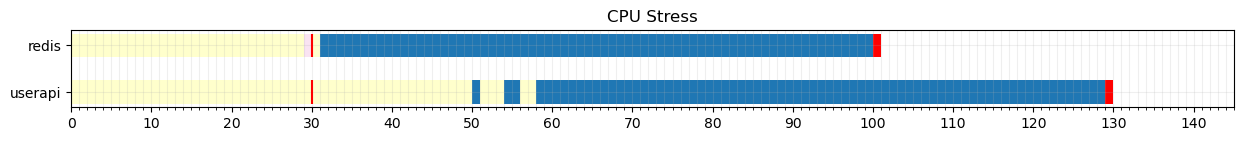

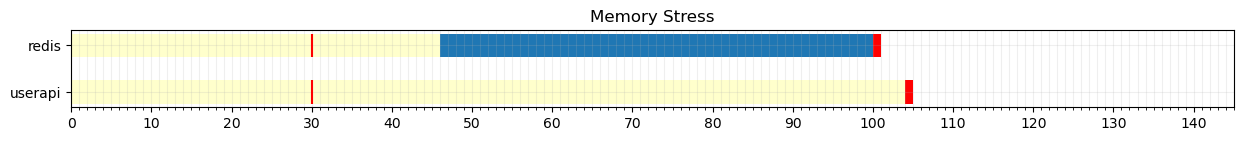

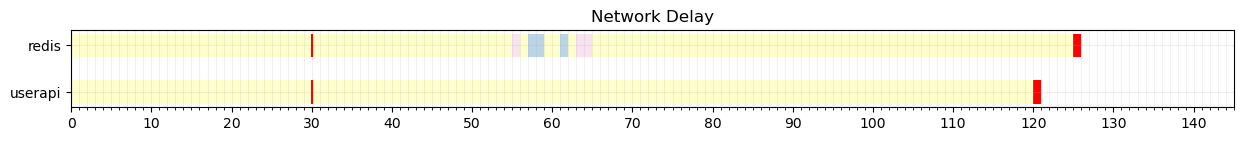

In [35]:
for failure_type in ["CPU Stress", "Memory Stress", "Network Delay"]:
    fig, ax = plt.subplots(figsize=(15, 1))
    ax.set_title(failure_type)

    yticks = []
    ax.set_xlim(0, 145)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.grid(which="both", alpha=0.2)

    line_shift = 0
    for _, failure_log in df_failure_logs[
        df_failure_logs["FAILURE_TYPE"] == failure_type
    ].iterrows():
        failure_name = failure_log["folder_name"]
        attacked_service = failure_log["SERVICE"]
        yticks.append(attacked_service)

        # statistics
        num_false_alarms = 0
        num_miss_alarms = 0
        false_localizations = 0
        true_localizations = 0

        df_failure = failure_experiment_dict[failure_name]

        predictions = results[failure_name]["predictions"]
        localizations = results[failure_name]["localizations"]

        failure_log = df_failure_logs[
            df_failure_logs["folder_name"] == failure_name
        ].iloc[0]

        failure_begin_timestamp = datetime.fromisoformat(
            failure_log["failure_begin_timestamp"]
        ).timestamp()
        experiment_begin_timestamp = datetime.fromisoformat(
            failure_log["experiment_begin_timestamp"]
        ).timestamp()
        failure_injection_index = int(
            (failure_begin_timestamp - experiment_begin_timestamp) / 60
        )
        disruption_index = int(failure_log["Disruption"])

        # failure injection point
        ax.vlines(30, line_shift + 1, line_shift, color="red")

        # consider only 30 minutes before injection
        if failure_injection_index > 30:
            start_index = failure_injection_index - 30
        else:
            start_index = 0
        end_index = disruption_index
        predictions = predictions[start_index:end_index]
        localizations = localizations[start_index:end_index]

        for time_point in range(len(predictions)):
            prediction = predictions[time_point]
            localization = localizations[time_point]

            if prediction:
                if time_point < 30:
                    num_false_alarms += 1
                    ax.broken_barh(
                        [(time_point, 1)],
                        (line_shift, 1.0),
                        facecolors=("tab:pink"),
                        alpha=0.2,
                    )
                else:
                    if localization == 1:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:blue"),
                            alpha=1,
                        )
                        true_localizations += 1

                    elif localization == 2:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:blue"),
                            alpha=0.3,
                        )
                        true_localizations += 1

                    elif localization == 0:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:pink"),
                            alpha=0.2,
                        )
                        false_localizations += 1
            else:
                ax.broken_barh(
                    [(time_point, 1)],
                    (line_shift, 1.0),
                    facecolors=("yellow"),
                    alpha=0.2,
                )
                if time_point >= 30:
                    num_miss_alarms += 1

        # compute statistics
        false_alarm_rate = int(100 * num_false_alarms / 30 + 0.5)
        print(f"{failure_type} {attacked_service} false alarm rate: {false_alarm_rate}")

        miss_alarm_rate = int(100 * num_miss_alarms / (len(predictions) - 30) + 0.5)
        print(f"{failure_type} {attacked_service} miss alarm rate: {miss_alarm_rate}")

        false_localization_rate = int(
            100 * false_localizations / (len(predictions) - 30) + 0.5
        )
        print(
            f"{failure_type} {attacked_service} false localization rate: {false_localization_rate}"
        )

        overall_localization_rate = int(
            100 * true_localizations / (len(predictions) - 30) + 0.5
        )
        print(
            f"{failure_type} {attacked_service} overall true localization rate: {overall_localization_rate}"
        )
        print(
            f"{false_alarm_rate}\% & {miss_alarm_rate}\% & {false_localization_rate}\% & {overall_localization_rate}\%"
        )
        baseline_statistcis.append(
            (
                failure_type.lower(),
                attacked_service,
                false_alarm_rate,
                miss_alarm_rate,
                false_localization_rate,
                overall_localization_rate,
            )
        )

        ax.broken_barh(
            [(time_point + 1, 1)], (line_shift, 1.0), facecolors=("red"), alpha=1
        )
        line_shift += 2

    ax.set_yticks(
        [i * 2 + 0.5 for i in range(2)],
        yticks,
    )

    plt.savefig(
        f"Alemira_{failure_type}_baseline.pdf", format="pdf", bbox_inches="tight"
    )

In [36]:
df_baseline_statistcis = pd.DataFrame(
    baseline_statistcis,
    columns=[
        "failure_type",
        "attacked_service",
        "false_alarm_rate",
        "miss_alarm_rate",
        "false_localization_rate",
        "overall_localization_rate",
    ],
)
df_baseline_statistcis.to_csv("Alemira_baseline_statistcis.csv", index=False)